---

# CSCI 3202, Fall 2021

# Lecture 28 - Hidden Markov Model Example
# November 1, 2021

<br> 

### Your name:

<br> 

---

Some useful packages and libraries:



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq
import unittest
from scipy import stats
import copy as cp
from time import time

---

## Markov Models 
 

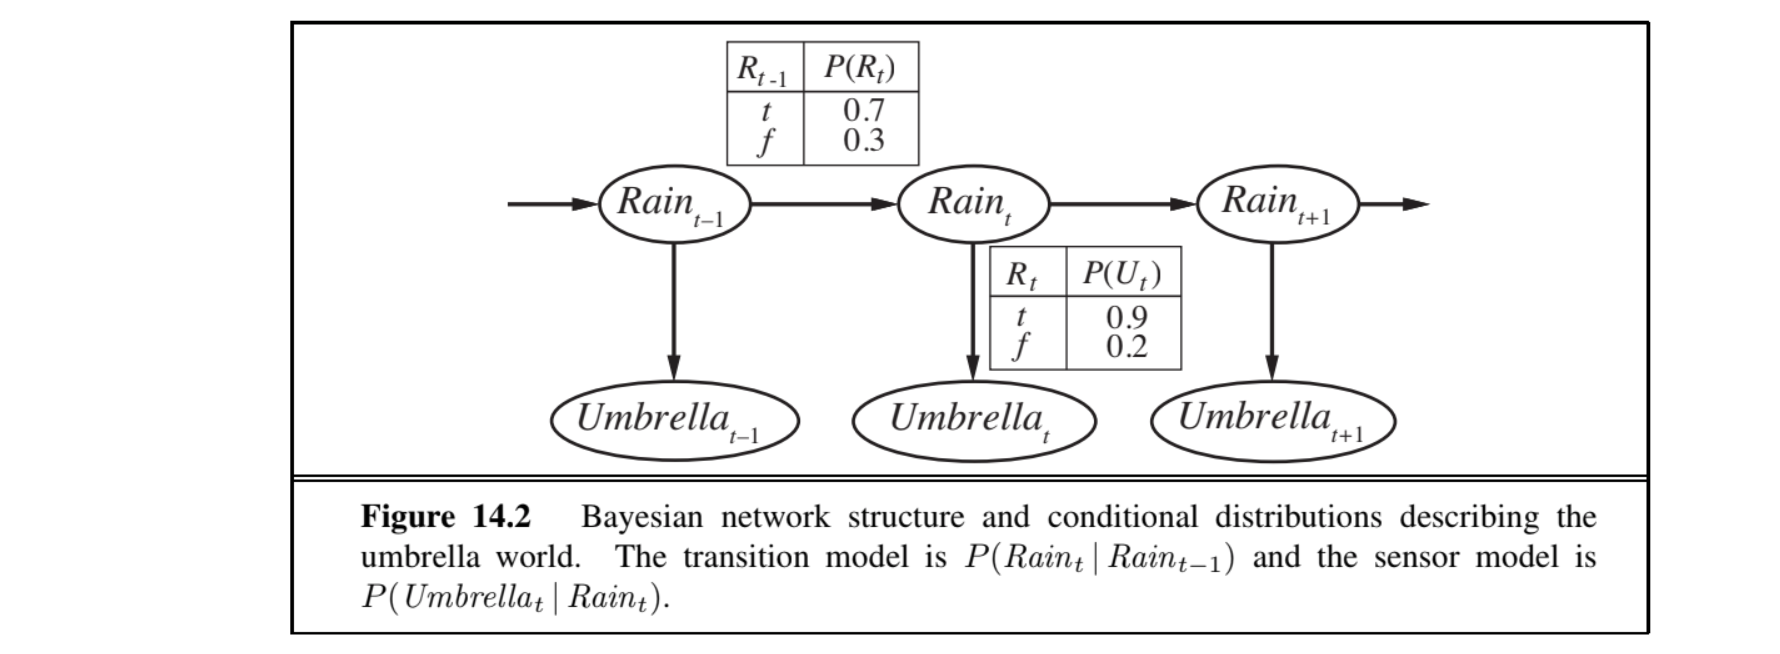

### (a) 

Use the Verterbi Algorithm given in section 14.2 of our textbook to generate the following result in "umbrella world" if we suppose that the observed umbrella sequence for the security guard's first five days on the job is [true, true, false, true, true]

In [2]:

class HiddenMarkovModel:
    """A Hidden markov model which takes Transition model and Sensor model as inputs"""

    def __init__(self, transition_model, sensor_model, prior=None):
        self.transition_model = transition_model
        self.sensor_model = sensor_model
        self.prior = prior or [0.5, 0.5]

    def sensor_dist(self, ev):
        if ev is True:
            return self.sensor_model[0]
        else:
            return self.sensor_model[1]

In [3]:
umbrella_transition = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor = [[0.9, 0.2], [0.1, 0.8]]
umbrellaHMM = HiddenMarkovModel(umbrella_transition, umbrella_sensor)

In [4]:
def vector_add(a, b):
    """Component-wise addition of two vectors."""
    if not (a and b):
        return a or b
    if hasattr(a, '__iter__') and hasattr(b, '__iter__'):
        assert len(a) == len(b)
        return list(map(vector_add, a, b))
    else:
        try:
            return a + b
        except TypeError:
            raise Exception('Inputs must be in the same size!')

def element_wise_product(x, y):
    if hasattr(x, '__iter__') and hasattr(y, '__iter__'):
        assert len(x) == len(y)
        return [element_wise_product(_x, _y) for _x, _y in zip(x, y)]
    elif hasattr(x, '__iter__') == hasattr(y, '__iter__'):
        return x * y
    else:
        raise Exception('Inputs must be in the same size!')
            
def scalar_vector_product(x, y):
    """Return vector as a product of a scalar and a vector recursively."""
    return [scalar_vector_product(x, _y) for _y in y] if hasattr(y, '__iter__') else x * y

def normalize(dist):
    """Multiply each number by a constant such that the sum is 1.0"""
    if isinstance(dist, dict):
        total = sum(dist.values())
        for key in dist:
            dist[key] = dist[key] / total
            assert 0 <= dist[key] <= 1  # probabilities must be between 0 and 1
        return dist
    total = sum(dist)
    return [(n / total) for n in dist]

def forward(HMM, fv, ev):
    prediction = vector_add(scalar_vector_product(fv[0], HMM.transition_model[0]),
                            scalar_vector_product(fv[1], HMM.transition_model[1]))
    sensor_dist = HMM.sensor_dist(ev)

    return normalize(element_wise_product(sensor_dist, prediction))


def backward(HMM, b, ev):
    sensor_dist = HMM.sensor_dist(ev)
    prediction = element_wise_product(sensor_dist, b)

    return normalize(vector_add(scalar_vector_product(prediction[0], HMM.transition_model[0]),
                                scalar_vector_product(prediction[1], HMM.transition_model[1])))


def forward_backward(HMM, ev):
    """
    [Figure 15.4]
    Forward-Backward algorithm for smoothing. Computes posterior probabilities
    of a sequence of states given a sequence of observations.
    """
    t = len(ev)
    ev.insert(0, None)  # to make the code look similar to pseudo code

    fv = [[0.0, 0.0] for _ in range(len(ev))]
    b = [1.0, 1.0]
    sv = [[0, 0] for _ in range(len(ev))]

    fv[0] = HMM.prior

    for i in range(1, t + 1):
        fv[i] = forward(HMM, fv[i - 1], ev[i])
    for i in range(t, -1, -1):
        sv[i - 1] = normalize(element_wise_product(fv[i], b))
        b = backward(HMM, b, ev[i])

    sv = sv[::-1]

    return sv


def viterbi(HMM, ev):
    """
    [Equation 15.11]
    Viterbi algorithm to find the most likely sequence. Computes the best path and the
    corresponding probabilities, given an HMM model and a sequence of observations.
    """
    t = len(ev)
    ev = ev.copy()
    ev.insert(0, None)

    m = [[0.0, 0.0] for _ in range(len(ev) - 1)]

    # the recursion is initialized with m1 = forward(P(X0), e1)
    m[0] = forward(HMM, HMM.prior, ev[1])
    # keep track of maximizing predecessors
    backtracking_graph = []

    for i in range(1, t):
        m[i] = element_wise_product(HMM.sensor_dist(ev[i + 1]),
                                    [max(element_wise_product(HMM.transition_model[0], m[i - 1])),
                                     max(element_wise_product(HMM.transition_model[1], m[i - 1]))])
        backtracking_graph.append([np.argmax(element_wise_product(HMM.transition_model[0], m[i - 1])),
                                   np.argmax(element_wise_product(HMM.transition_model[1], m[i - 1]))])

    # computed probabilities
    ml_probabilities = [0.0] * (len(ev) - 1)
    # most likely sequence
    ml_path = [True] * (len(ev) - 1)

    # the construction of the most likely sequence starts in the final state with the largest probability, and
    # runs backwards; the algorithm needs to store for each xt its predecessor xt-1 maximizing its probability
    i_max = np.argmax(m[-1])

    for i in range(t - 1, -1, -1):
        ml_probabilities[i] = m[i][i_max]
        ml_path[i] = True if i_max == 0 else False
        if i > 0:
            i_max = backtracking_graph[i - 1][i_max]

    return ml_path, ml_probabilities



In [5]:
umbrella_evidence = [True, True, False, True, True]

viterbi(umbrellaHMM, umbrella_evidence)

([True, True, False, True, True],
 [0.8181818181818181,
  0.5154545454545454,
  0.12370909090909088,
  0.03340145454545454,
  0.02104291636363636])